In [29]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import XGate, MCMT
from PIL import Image as im
import requests
import base64
import matplotlib.pyplot as plt
import io

In [30]:
def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    img = im.open(io.BytesIO(requests.get('https://mermaid.ink/img/' + base64_string).content))
    plt.imshow(img)
    plt.axis('off') # allow to hide axis
    plt.savefig('image.png', dpi=1200)

In [31]:
def map_graph(edges, registry_size: int = 2, directed: bool = False):
    circ = QuantumCircuit((2 * registry_size) + 1, name='Graph Verify')
    def map_edge(from_node: int, to_node: int):
        target_qubit = (2 * registry_size)
        def add_x(number, start_qubit):
            exp = 1
            for qubit in range(start_qubit, start_qubit + registry_size):
                if not (number & exp):
                    circ.x(qubit)
                exp *= 2

        add_x(from_node, 0)
        add_x(to_node, registry_size)
        circ.append(XGate().control(registry_size * 2), list(range((2 * registry_size))) + [target_qubit])
        add_x(from_node, 0)
        add_x(to_node, registry_size)
    for e in edges:
        map_edge(e[0], e[1])
        circ.barrier()
        if not directed:
            map_edge(e[1], e[0])
            circ.barrier()
    return circ



In [32]:
class MazeCircuitGenerator:

    def __init__(self, node_bits_size: int, max_steps_count: int, directed_graph: bool = False):
        self.__node_bits_size = node_bits_size
        self.__max_steps_count = max_steps_count
        self.__directed_graph = directed_graph
        self.__edges = []

    def add_edges(self, edges: list[tuple]) -> 'MazeCircuitGenerator':
        self.__edges += edges
        return self

    def add_edge(self, edge: tuple[int]) -> 'MazeCircuitGenerator':
        self.add_edges([edge])
        return self
    
    def __map_graph(self, circ, start_qubit, target_qubit: int):
        def map_edge(from_node: int, to_node: int):
            def add_x(number, start_qubit):
                exp = 1
                for qubit in range(start_qubit, start_qubit + self.__node_bits_size):
                    if not (number & exp):
                        circ.x(qubit)
                    exp *= 2

            add_x(from_node, start_qubit)
            add_x(to_node, start_qubit + self.__node_bits_size)
            circ.append(XGate().control(self.__node_bits_size * 2), list(range(start_qubit, (2 * self.__node_bits_size) + start_qubit)) + [target_qubit])
            add_x(from_node, 0)
            add_x(to_node, self.__node_bits_size)
        for e in self.__edges:
            map_edge(e[0], e[1])
            circ.barrier()
            if not self.__directed_graph:
                map_edge(e[1], e[0])
                circ.barrier()
        return circ

    # def generate(self):
    #     steps_qubit_count = (self.__max_steps_count + 1) * self.__node_bits_size
    #     print(steps_qubit_count)
    #     circ = QuantumCircuit(steps_qubit_count + self.__max_steps_count)
    #     print(steps_qubit_count + self.__max_steps_count)        
    #     for s in range(self.__max_steps_count):
    #         circ = self.__map_graph(circ, self.__node_bits_size * s, steps_qubit_count + s)
    #     return circ

    def __negate(self, num_qubits: int) -> QuantumCircuit:
        n = QuantumCircuit(num_qubits)
        for i in range(num_qubits):
            n.z(i)
            n.x(i)
            n.z(i)
            n.x(i)
        return n

    def generate(self):
        steps_qubit_count = (self.__max_steps_count + 1) * self.__node_bits_size
        circ = QuantumCircuit(steps_qubit_count + self.__max_steps_count)
        graph_circ = map_graph(self.__edges, self.__node_bits_size, self.__directed_graph)
        for s in range(self.__max_steps_count):
            start_qubit = s * self.__node_bits_size
            circ.append(graph_circ, list(range(start_qubit, start_qubit + 2 * self.__node_bits_size)) + [steps_qubit_count + s])
        self.flip_circ = MCMT(self.__negate(1), self.__max_steps_count, steps_qubit_count)
        self.flip_circ.name = 'Flip'
        circ.append(self.flip_circ, list(range(steps_qubit_count, steps_qubit_count + self.__max_steps_count)) + list(range(steps_qubit_count)))
        return circ


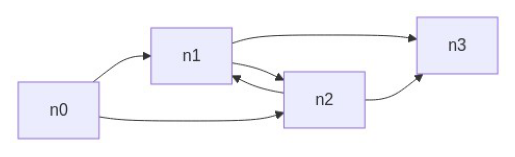

In [33]:
mm("""
flowchart LR;
   n0 --> n1 & n2
   n1 & n2 --> n3
   n1 --> n2
   n2 --> n1
""")

In [34]:
edges = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 3)
]

In [35]:
oracle = MazeCircuitGenerator(node_bits_size=2, max_steps_count=2, directed_graph=False).add_edges(edges).generate()
oracle.name = 'oracle'

C:\Users\admin\AppData\Local\Temp\ipykernel_17344\199432537.py:64: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  self.flip_circ = MCMT(self.__negate(1), self.__max_steps_count, steps_qubit_count)


In [36]:
circ = QuantumCircuit(8)
for i in range(6):
    circ.h(i)
circ.append(oracle, list(range(8)))

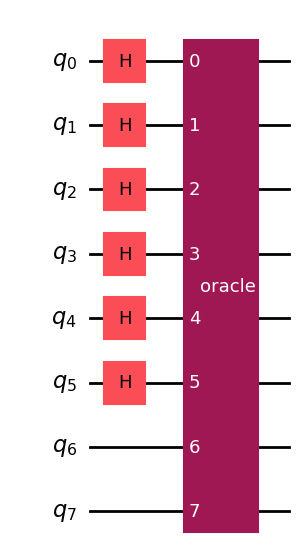

In [37]:
circ.draw('mpl')

In [38]:
#Settings per gestire il diffusore: Funzione G
import numpy as np
QUBITS = 8
N = 6 #QUBITS del circuito
M = 1 #Soluzioni
theta = np.arccos(np.sqrt((N-M)/N))*2 #Angolo di rotazione della funzione G
ktot = (np.pi/2)*theta #Numero totale di rotazioni
reps:int = np.ceil(ktot) #Numero di ripetizioni integer
print(theta, reps.astype(int))


0.84106867056793 2


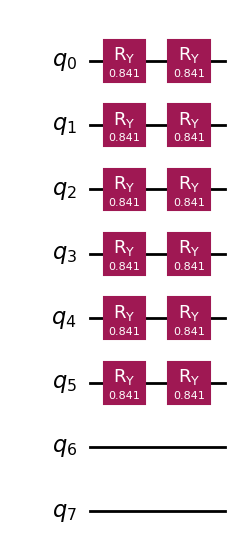

In [39]:
#L'effetto complessivo del diffusore sono k ripetizioni di rotazioni di theta
#Da quel che ho capito non serve riapplicare l'oracolo
G_circ = QuantumCircuit(QUBITS)

for i in range(reps.astype(int)):
    G_circ.ry(theta, range(N))
    
G_circ.name = 'G'
G_circ.draw("mpl", style = "iqp")

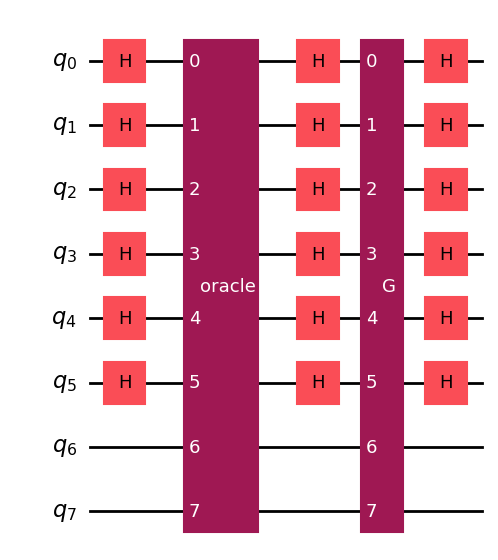

In [40]:
#Il diffusore si applica solo ai qubit del circuito, non alle ancille
circ.h(range(N))
circ.append(G_circ, list(range(QUBITS)))
circ.h(range(N))
circ.draw("mpl")

In [56]:
import os
import sys
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import GroverOperator
sys.path.insert(1, '../')
from utils import Helpers as hp
oracle = QuantumCircuit(4)
grover_op = GroverOperator(oracle, insert_barriers=True)
grover_op.decompose().draw()
# hp.derive_unitary_matrix(grover_op)

global phase: π
          ░ ┌───┐ ░ ┌───┐          ┌───┐      ░ ┌───┐
state_0: ─░─┤ H ├─░─┤ X ├───────■──┤ X ├──────░─┤ H ├
          ░ ├───┤ ░ ├───┤       │  ├───┤      ░ ├───┤
state_1: ─░─┤ H ├─░─┤ X ├───────■──┤ X ├──────░─┤ H ├
          ░ ├───┤ ░ ├───┤       │  ├───┤      ░ ├───┤
state_2: ─░─┤ H ├─░─┤ X ├───────■──┤ X ├──────░─┤ H ├
          ░ ├───┤ ░ ├───┤┌───┐┌─┴─┐├───┤┌───┐ ░ ├───┤
state_3: ─░─┤ H ├─░─┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├─░─┤ H ├
          ░ └───┘ ░ └───┘└───┘└───┘└───┘└───┘ ░ └───┘

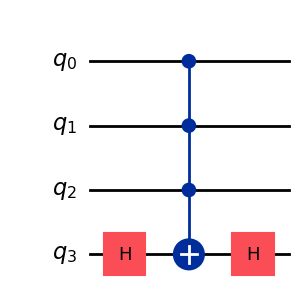

In [ ]:
from qiskit.circuit.library import ZGate
oracle = QuantumCircuit(4)
oracle.h(0)
oracle.h(1)
oracle.h(2)
oracle.h(3)

oracle.x(0)
oracle.x(1)
oracle.x(2)
oracle.x(3)

oracle.append(ZGate().control(3), [0, 1, 2, 3])
oracle.x(0)
oracle.x(1)
oracle.x(2)
oracle.x(3)

oracle.h(0)
oracle.h(1)
oracle.h(2)
oracle.h(3)

oracle.decompose().draw('mpl')
# hp.derive_unitary_matrix(oracle)
